# Imports

In [1]:
import os
import nba_py
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def read_db():
    """Read data from db.
    Returns:
        pandas dataframe.
    """
    
    # -- Load data from db.
    with sqlite3.connect("../data/outputs/NBA_ELO.db") as conn:
        return pd.read_sql("SELECT * FROM nba_elo", conn, 
                           index_col="index", parse_dates=["date_game"])
    
def last_elo(df):
    """Calculate the last ELO for each team (past 2016).
    Args:
        df - pandas dataframe containing database table.
    Returns:
        last_elo (dict) - dictionary where tm: elo score.
        max_date - last date in table.
    """

    last_elo = {}
    max_date = pd.datetime(2014, 1, 1)
    for tm in df[df.date_game > pd.datetime(2016, 1, 1)].team_id_away.unique():
        try:
            # -- Subset table to get most recent record with an ELO rating.
            tmp = df[((~df.elo_i_home.isnull()) & (df.team_id_away == tm)) |
                     ((~df.elo_i_home.isnull()) & (df.team_id_home == tm))] \
                    .sort_values("date_game").iloc[-1]
            max_date = max(max_date, tmp.date_game)
        except:
            print("Error with: {}".format(tm))
        # -- Store ELO in dictionary.
        if tmp.team_id_home == tm:
            last_elo[tm] = tmp.elo_n_home
        else:
            last_elo[tm] = tmp.elo_n_away

    return last_elo, max_date

# Calculate New Elo

In [3]:
df = read_db()
df.to_csv(os.path.join("..", "data", "outputs", "nba_elo.csv"))
df.iloc[-5:, :]

,date_game,elo_i_away,elo_i_home,elo_n_away,elo_n_home,pts_away,pts_home,team_id_away,team_id_home
index,,,,,,,,,
65769,2017-05-21,1561.359587,1673.778590,1571.766116,1663.372061,111,108,BOS,CLE
65770,2017-05-22,1845.081343,1667.019022,1854.511970,1657.588395,129,115,GSW,SAS
65771,2017-05-23,1571.766116,1663.372061,1566.471345,1668.666832,99,112,BOS,CLE
65772,2017-05-25,1668.666832,1566.471345,1691.919114,1543.219062,135,102,CLE,BOS
65773,2017-06-01,1691.919114,1854.511970,1686.689508,1859.741577,91,113,CLE,GSW


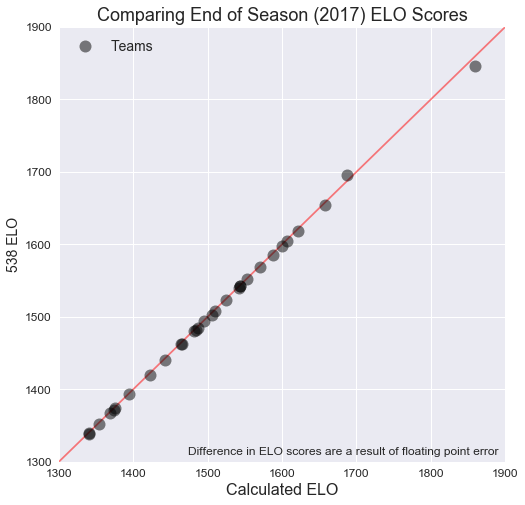

In [4]:
mine, last_date = last_elo(df)
silver = {u'ATL': 1480, u'BOS': 1542, u'BRK': 1372, u'CHA': 1463, u'CHI': 1494,
          u'CLE': 1696, u'DAL': 1420, u'DEN': 1552, u'DET': 1441, u'GSW': 1846,
          u'HOU': 1598, u'IND': 1502, u'LAC': 1619, u'LAL': 1367, u'MEM': 1484,
          u'MIA': 1569, u'MIL': 1508, u'MIN': 1463, u'NOP': 1482, u'NYK': 1374,
          u'OKC': 1523, u'ORL': 1352, u'PHI': 1338, u'PHO': 1340, u'POR': 1540, 
          u'SAC': 1393, u'SAS': 1654, u'TOR': 1542, u'UTA': 1605, u'WAS': 1586}

vals = []
for key in silver.keys():
    vals.append((mine[key], silver[key]))
vals = pd.DataFrame(vals)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot((1300, 1900), (1300, 1900), c="r", alpha=0.5)
ax.plot(vals.iloc[:,0], vals.iloc[:,1], marker="o", markersize=12, 
        ls="", c="k", alpha=0.5, label="Teams")
ax.set_ylim(1300, 1900)
ax.set_xlim(1300, 1900)
ax.legend(fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xlabel("Calculated ELO", fontsize=16)
ax.set_ylabel("538 ELO", fontsize=14)
ax.set_title("Comparing End of Season (2017) ELO Scores", fontsize=18)
ax.text(1900 * .995, 1300 * 1.005, "Difference in ELO scores are a result of floating point error", 
        ha="right", va="bottom", fontsize=12)
fig.savefig("../data/outputs/elo_comparison.png")